In [25]:
# ============================================
# 1) Imports & basic config
# ============================================
import os
import math
import json
import warnings
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Any, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True

# Repro
SEED = 42
np.random.seed(SEED)

In [26]:
# ============================================
# 2) Utility helpers (Python 3.9-compatible)
#    - Robust CSV loader
#    - Per-series tail split (holdout)
#    - Covariates alignment (train/test/future)
# ============================================

def _find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Return first matching column (case-insensitive) or None."""
    lower = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name.lower() in lower:
            return lower[name.lower()]
    return None


def split_train_val_last_n(
        ts: TimeSeriesDataFrame, holdout_days: int
) -> Tuple[TimeSeriesDataFrame, TimeSeriesDataFrame]:
    """
    Split a TimeSeriesDataFrame into train/val by taking the last `holdout_days`
    from each series as validation.

    Works across AutoGluon versions by treating TimeSeriesDataFrame as a pandas.DataFrame.
    Ensures item_id/timestamp are preserved.
    """
    # In your AG version, TimeSeriesDataFrame is a subclass of pandas.DataFrame.
    pdf = ts.copy()

    # Ensure MultiIndex [item_id, timestamp]; if not, try to build it
    if not isinstance(pdf.index, pd.MultiIndex):
        if {"item_id", "timestamp"}.issubset(pdf.columns):
            pdf = pdf.set_index(["item_id", "timestamp"]).sort_index()
        else:
            raise ValueError(
                "Expected a MultiIndex [item_id, timestamp] or columns ['item_id','timestamp'] "
                "to construct the index."
            )

    train_rows = []
    val_rows = []

    # Group by item_id (level=0) and slice each series
    for sid, df_sid in pdf.groupby(level=0):
        # df_sid index is [item_id, timestamp]; drop item_id level for slicing
        df_sid = df_sid.droplevel(0)

        if len(df_sid) <= holdout_days:
            # too short – skip this series entirely
            continue

        tr = df_sid.iloc[:-holdout_days].copy()
        va = df_sid.iloc[-holdout_days:].copy()

        # Reattach item_id/timestamp as columns for from_data_frame
        tr["item_id"] = sid
        va["item_id"] = sid
        tr = tr.reset_index().rename(columns={"index": "timestamp"})
        va = va.reset_index().rename(columns={"index": "timestamp"})

        train_rows.append(tr)
        val_rows.append(va)

    if not train_rows or not val_rows:
        raise ValueError(
            "After splitting, one of the splits is empty. "
            "Decrease `holdout_days` or ensure enough history per series."
        )

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)

    # IMPORTANT: in your AG version, from_data_frame(df, id_column, timestamp_column)
    # expects the target column to already be named 'target'
    train_ts = TimeSeriesDataFrame.from_data_frame(train_df, "item_id", "timestamp")
    val_ts = TimeSeriesDataFrame.from_data_frame(val_df, "item_id", "timestamp")
    return train_ts, val_ts


def load_and_prepare(
        csv_path: Union[str, Path],
        date_col: Optional[str] = None,
        target_col: Optional[str] = None,
        item_id_col: Optional[str] = None,
        known_covars: Optional[List[str]] = None,
        freq: str = "D",
        holdout_days: int = 28,
) -> Tuple[TimeSeriesDataFrame, TimeSeriesDataFrame, Optional[TimeSeriesDataFrame], Dict[str, Any]]:
    """
    Read a CSV and return:
      - train_data: TimeSeriesDataFrame (for predictor.fit)
      - test_data:  TimeSeriesDataFrame (last `holdout_days` of each series)
      - cov_test:   TimeSeriesDataFrame with known covariates aligned to test_data (or None)
      - meta:       dict with info

    Py3.9 / older AutoGluon-TS compatible:
      * TimeSeriesDataFrame.from_data_frame(df, id_column, timestamp_column)
        expects the target column to be named 'target' beforehand.
    """

    # --------- 0) Load CSV
    csv_path = str(csv_path)
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError("CSV is empty.")
    df.columns = [c.strip() for c in df.columns]

    # --------- 1) Resolve column names (case-insensitive fallback)
    def _find_col(candidates: List[str]) -> Optional[str]:
        lower = {c.lower(): c for c in df.columns}
        for cand in candidates:
            if cand.lower() in lower:
                return lower[cand.lower()]
        return None

    if date_col is None:
        date_col = _find_col(["dt", "date", "timestamp", "time", "datetime"])
    if target_col is None:
        target_col = _find_col(["request_cnt", "y", "target", "value"])
    if date_col is None or target_col is None:
        raise ValueError(
            f"Could not resolve date_col or target_col. Found date_col={date_col}, target_col={target_col}. "
            f"Pass them explicitly."
        )

    # If no item_id, synthesize a single-series id
    synthesized_id = False
    if item_id_col is None or item_id_col not in df.columns:
        item_id_col = "__series_id__"
        df[item_id_col] = "series_0"
        synthesized_id = True

    # --------- 2) Parse timestamp & basic cleaning
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=False)
    df = df.dropna(subset=[date_col, target_col])
    df = df.sort_values([item_id_col, date_col])

    # Aggregate duplicates on same timestamp per item (sum counts)
    if df.duplicated([item_id_col, date_col]).any():
        df = (
            df.groupby([item_id_col, date_col], as_index=False)
            .agg({**{target_col: "sum"},
                  **{c: "last" for c in df.columns
                     if c not in [item_id_col, date_col, target_col]}})
        )

    # --------- 3) Build the TimeSeriesDataFrame for target
    df_ts = df[[item_id_col, date_col, target_col]].copy()
    df_ts = df_ts.rename(columns={target_col: "target"})
    ts = TimeSeriesDataFrame.from_data_frame(df_ts, item_id_col, date_col)

    # Regularize to a strict frequency
    ts = ts.convert_frequency(freq=freq, agg_numeric="sum")

    # Sanity checks
    assert ts.index.is_monotonic_increasing, "Non-monotonic timestamps"
    assert ts.index.levels[1].inferred_type in {"datetime64", "datetime"}, "Non-datetime index"
    if "target" in ts.columns:
        assert ts["target"].notna().all(), "Missing targets after aggregation"

    # --------- 4) Build known covariates (optional) and align frequency
    cov_ts_full = None
    if known_covars:
        present_covs = [c for c in known_covars if c in df.columns]
        if present_covs:
            df_cov = df[[item_id_col, date_col] + present_covs].copy()
            if df_cov.duplicated([item_id_col, date_col]).any():
                df_cov = (
                    df_cov.groupby([item_id_col, date_col], as_index=False)
                    .agg({**{c: "sum" for c in present_covs}})
                )
            cov_ts_full = TimeSeriesDataFrame.from_data_frame(df_cov, item_id_col, date_col)
            cov_ts_full = cov_ts_full.convert_frequency(freq=freq, agg_numeric="sum")

            # 🔧 FIX: avoid adding a 3rd index level during groupby-apply
            cov_ts_full = (
                cov_ts_full
                .groupby(level=0, group_keys=False)
                .apply(lambda g: g.ffill().bfill())
            )

    # --------- 5) Train/Validation split: last `holdout_days` per series
    def _split_last_n(ts: TimeSeriesDataFrame, n_last: int) -> Tuple[TimeSeriesDataFrame, TimeSeriesDataFrame]:
        """
        Vectorized split: returns (train_ts, val_ts) where val_ts is the last n rows per item.
        """
        pdf = ts.sort_index() if not isinstance(ts, pd.DataFrame) else ts.sort_index()
        idx = pdf.index
        counts = pdf.groupby(level=0).size()
        pos = pdf.groupby(level=0).cumcount()
        is_val = pos >= (counts.reindex(idx.get_level_values(0)).values - n_last)
        train_pdf = pdf.loc[~is_val]
        val_pdf = pdf.loc[is_val]
        return TimeSeriesDataFrame(train_pdf), TimeSeriesDataFrame(val_pdf)

    train_data, test_data = _split_last_n(ts, holdout_days)

    # --------- 6) Slice known covariates to the test window (optional)
    cov_test = None
    if cov_ts_full is not None and not test_data.empty:
        # Align covariates exactly to test index (MultiIndex [item_id, timestamp])
        cov_test = cov_ts_full.reindex(test_data.index)

        # 🔧 FIX: ffill/bfill without adding an extra index level
        cov_test = (
            cov_test
            .groupby(level=0, group_keys=False)
            .apply(lambda g: g.ffill().bfill())
            .fillna(0.0)
        )

    # --------- 7) Meta info
    meta: Dict[str, Any] = {
        "path": csv_path,
        "date_col": date_col,
        "target_col": target_col,
        "item_id_col": item_id_col,
        "synthesized_item_id": synthesized_id,
        "known_covars": known_covars or [],
        "freq": freq,
        "holdout_days": holdout_days,
        "n_series_total": int(ts.index.get_level_values(0).nunique()),
        "n_train_rows": int(len(train_data)),
        "n_test_rows": int(len(test_data)),
        "train_start": str(train_data.index.get_level_values(1).min()) if not train_data.empty else None,
        "train_end": str(train_data.index.get_level_values(1).max()) if not train_data.empty else None,
        "test_start": str(test_data.index.get_level_values(1).min()) if not test_data.empty else None,
        "test_end": str(test_data.index.get_level_values(1).max()) if not test_data.empty else None,
    }

    return train_data, test_data, cov_test, meta


def make_future_covariates_from_last(
        hist_covars: Optional[pd.DataFrame],
        future_index: pd.MultiIndex
) -> Optional[pd.DataFrame]:
    """
    Simple baseline for future known covariates:
      - forward-fill last known value per series across the requested future_index.
    """
    if hist_covars is None or hist_covars.empty:
        return None
    # Last row per [item_id] to use as constant forward value
    latest = hist_covars.groupby(level=0).tail(1)
    # Reindex to future grid and ffill per item
    cov_future = latest.reindex(future_index, level=0).groupby(level=0).ffill()
    return cov_future

In [27]:
# ============================================
# 3) Configuration (edit these for your CSV)
# ============================================

# Path to your daily_requests_summary.csv (or any long-format daily CSV)
CSV_PATH = "input/daily_requests_summary.csv"

# Column names in your CSV (case-insensitive inference if None)
DATE_COL = "dt"  # e.g. "dt"
TARGET_COL = "request_cnt"  # what you want to forecast
ITEM_ID_COL = None  # set to a column if you have multiple series (e.g., "store_id")

# Optional known covariates present in your CSV
KNOWN_COVARS = ["total_color_kg", "distinct_user_creators", "distinct_colors"]  # edit/remove as needed

# Time settings
FREQ = "D"  # daily data
HOLDOUT_DAYS = 28  # last N days per series reserved for validation

# Training budget
TIME_LIMIT_S = 600  # seconds

# Output dir to store models & artifacts
OUT_DIR = Path("autogluon_ts_output")
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [28]:
# ============================================
# 4) Load & prepare data
# ============================================
train_data, test_data, cov_test, meta = load_and_prepare(
    csv_path=CSV_PATH,
    date_col=DATE_COL,
    target_col=TARGET_COL,
    item_id_col=ITEM_ID_COL,
    known_covars=KNOWN_COVARS,
    freq=FREQ,
    holdout_days=HOLDOUT_DAYS,
)

print("Meta:", json.dumps(meta, indent=2))
print("\nTrain shape:", train_data.shape, "| Test shape:", test_data.shape)
display(train_data.head())

Meta: {
  "path": "input/daily_requests_summary.csv",
  "date_col": "dt",
  "target_col": "request_cnt",
  "item_id_col": "__series_id__",
  "synthesized_item_id": true,
  "known_covars": [
    "total_color_kg",
    "distinct_user_creators",
    "distinct_colors"
  ],
  "freq": "D",
  "holdout_days": 28,
  "n_series_total": 1,
  "n_train_rows": 1040,
  "n_test_rows": 28,
  "train_start": "2022-10-10 00:00:00",
  "train_end": "2025-08-14 00:00:00",
  "test_start": "2025-08-15 00:00:00",
  "test_end": "2025-09-11 00:00:00"
}

Train shape: (1040, 1) | Test shape: (28, 1)


target
item_id  timestamp         
series_0 2022-10-10      22
         2022-10-11      25
         2022-10-12      12
         2022-10-13      11
         2022-10-14      35

In [29]:
# ============================================
# 5) Configure & train the predictor
# ============================================
from autogluon.timeseries import TimeSeriesPredictor

PREDICTION_LENGTH = meta["holdout_days"]
FREQ = meta["freq"]

# FAST CPU-FRIENDLY CONFIG
fast_hyperparameters = {
    "SeasonalNaive": {},
    "AutoETS": {},
    "NPTS": {},
    "Theta": {},     # aka DynamicOptimizedTheta in some logs
    "ARIMA": {},     # lightweight classical model
    "RecursiveTabular": {"max_leaves": 64, "num_layers": 2},
    "DirectTabular": {"max_leaves": 64, "num_layers": 2},
    # Keep deep models tiny on CPU
    "TemporalFusionTransformer": {"epochs": 3, "dropout_rate": 0.2},
    "DeepAR": {"epochs": 3},
    "PatchTST": {"epochs": 3},
    "TiDE": {"epochs": 3},
}

predictor = TimeSeriesPredictor(
    prediction_length=PREDICTION_LENGTH,
    freq=FREQ,
    eval_metric="sMAPE",
    quantile_levels=[0.1, 0.5, 0.9],
    verbosity=2,
)

# IMPORTANT: No known_covariates here for older AG versions
predictor.fit(
    train_data=train_data,
    time_limit=TIME_LIMIT_S,                  # adjust for speed/accuracy
    hyperparameters=fast_hyperparameters,
)

# Backtesting across 3 windows for stability
try:
    bt = predictor.backtest(data=train_data, num_val_windows=3, val_step_size=PREDICTION_LENGTH, use_cache=True)
    bt.to_csv(OUT_DIR / "backtest.csv", index=False)
    display(bt.head())
except Exception as e:
    print("Backtest skipped:", e)

# Optional: cap extreme outliers per item at 99th percentile
try:
    pdf_hist = train_data.copy()
    cap_map = pdf_hist.groupby(level=0)["target"].quantile(0.99)
    def cap_group(g):
        cap = cap_map.loc[g.index.get_level_values(0)[0]]
        g.loc[:, "target"] = np.minimum(g["target"], cap)
        return g
    train_data = TimeSeriesDataFrame(pdf_hist.groupby(level=0, group_keys=False).apply(lambda g: cap_group(g)))
except Exception as e:
    print("Outlier capping skipped:", e)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/Users/katarov/PycharmProjects/flex-ml-python/AutogluonModels/ag-20250916_095753'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250915
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:29 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          1
Memory Avail:       4.99 GB / 16.00 GB (31.2%)
Disk Space Avail:   19.65 GB / 460.43 GB (4.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'D',
 'hyperparameters': {'ARIMA': {},
                     'AutoETS': {},
                     'DeepAR': {'epochs': 3},
                     'DirectTabular': {'max_leaves': 64, 'num_layers': 2},
                     'NPTS': {},
                     'PatchTST': {'epochs': 3},
                     'RecursiveTabular': {'max_

Backtest skipped: 'TimeSeriesPredictor' object has no attribute 'backtest'


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
/Users/katarov/flex-ml/flex-ml-python/.venv/lib/python3.9/site-packages/autogluon/timeseries/models/local/npts.py:81: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts.index = ts.index.to_period(freq=dummy_freq)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,NPTS,-1.367387,-1.405062,0.099858,0.089579,0.003669,4
1,WeightedEnsemble,-1.369450,-1.397658,1.410875,0.105789,0.078271,8
2,SeasonalNaive,-1.406548,-1.424367,1.310430,0.016210,0.003508,1
3,AutoETS,-1.479205,-1.495835,0.075803,0.077278,0.003659,6
4,Theta,-1.481297,-1.498616,0.041683,0.733765,0.003974,5
5,RecursiveTabular,-1.513127,-1.531669,0.060975,0.051790,0.617103,2
6,ARIMA,-1.530270,-1.543980,0.016617,0.029007,0.003710,7
7,DirectTabular,-1.578789,-1.590344,0.030636,0.025900,0.572720,3


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/Users/katarov/flex-ml/flex-ml-python/.venv/lib/python3.9/site-packages/autogluon/timeseries/models/local/npts.py:81: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts.index = ts.index.to_period(freq=dummy_freq)


Manual holdout metrics: {'MAPE': 47058824.5156584, 'sMAPE': 0.6153594345212693, 'MAE': 8.543109243697472, 'RMSE': 12.150589642905867}


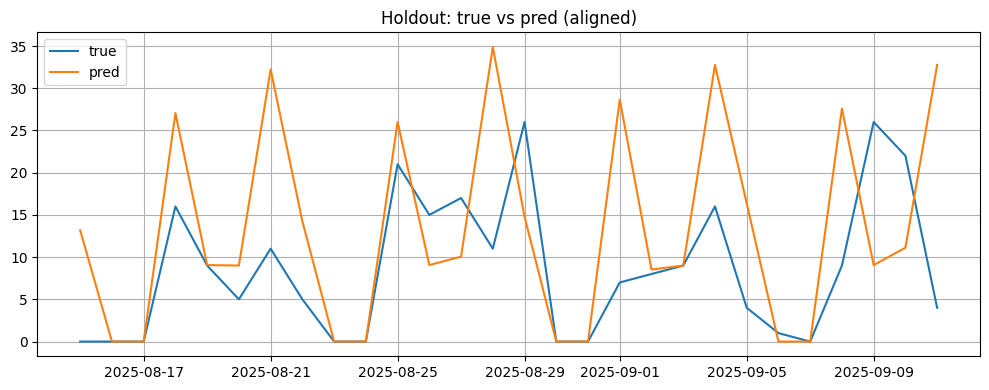

Worst 5 sMAPE:
item_id
series_0    0.615359
dtype: float64


In [30]:
# ============================================
# 6) Leaderboard (on training) & manual eval on holdout (FIXED)
# ============================================
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 6.1 Leaderboard on training data (always valid)
lb = predictor.leaderboard(train_data, silent=True)
display(lb)

# 6.2 Predict *from the end of training* so timestamps align with the holdout
#     DO NOT use test_data here, or predictions will land after the holdout.
y_pred_future = predictor.predict(train_data)

# 6.3 Align true vs pred on (item_id, timestamp)
true_df = (
    test_data.reset_index()[["item_id", "timestamp", "target"]]
    .rename(columns={"target": "y_true"})
)

pred_df = y_pred_future.reset_index()

# AutoGluon’s prediction DF often has a 'mean' column; if not, grab the first non-index column
if "mean" in pred_df.columns:
    pred_df = pred_df.rename(columns={"mean": "y_pred"})
else:
    non_idx_cols = [c for c in pred_df.columns if c not in ("item_id", "timestamp")]
    if not non_idx_cols:
        raise RuntimeError(f"No prediction column found in y_pred_future columns: {list(pred_df.columns)}")
    pred_df = pred_df.rename(columns={non_idx_cols[0]: "y_pred"})

# Merge and sanity-check
eval_df = pd.merge(true_df, pred_df, on=["item_id", "timestamp"], how="inner")

if eval_df.empty:
    # Helpful debug to understand why alignment failed
    print("DEBUG: eval_df is empty after merge.")
    print("true_df example:\n", true_df.head(), "\n")
    print("pred_df example:\n", pred_df.head(), "\n")
    print("Unique true timestamps (tail):", true_df["timestamp"].sort_values().tail().tolist())
    print("Unique pred timestamps (head):", pred_df["timestamp"].sort_values().head().tolist())
    raise RuntimeError(
        "No overlap between true and predicted timestamps. "
        "This usually happens if you predicted from test_data instead of train_data, "
        "or your train/test split isn’t contiguous."
    )

# 6.4 Metrics
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))))

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

metrics = {
    "MAPE": mape(eval_df["y_true"], eval_df["y_pred"]),
    "sMAPE": smape(eval_df["y_true"], eval_df["y_pred"]),
    "MAE": float(mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])),
    "RMSE": float(np.sqrt(np.mean((eval_df["y_true"] - eval_df["y_pred"]) ** 2))),
}
print("Manual holdout metrics:", metrics)

# Optional: quick plot (single series)
if eval_df["item_id"].nunique() == 1:
    import matplotlib.pyplot as plt
    g = eval_df.sort_values("timestamp")
    plt.figure(figsize=(10, 4))
    plt.plot(g["timestamp"], g["y_true"], label="true")
    plt.plot(g["timestamp"], g["y_pred"], label="pred")
    plt.title("Holdout: true vs pred (aligned)")
    plt.legend()
    plt.tight_layout()
    plt.show()
# Per-series diagnostics: worst 5 sMAPE
by_item = eval_df.groupby("item_id").apply(lambda g: float(np.mean(2*np.abs(g["y_pred"]-g["y_true"]) / (np.abs(g["y_pred"])+np.abs(g["y_true"])+1e-8)))).sort_values(ascending=False)
print("Worst 5 sMAPE:")
print(by_item.head(5))
by_item.to_csv(OUT_DIR / "per_item_smape.csv")


In [31]:
# ==============================
# 7) Forecast the next N days
# ==============================
import pandas as pd

# Choose how far ahead to forecast
FORECAST_DAYS = 100  # change as needed

# If your predictor was trained with prediction_length != FORECAST_DAYS,
# we can still roll forecasts forward by predicting multiple blocks.
# Utility: roll forward in blocks of predictor.prediction_length
def forecast_next_days(predictor, train_data, days_ahead: int, known_covariates=None):
    """
    Roll forecasts forward in blocks of prediction_length while preserving quantiles.
    """
    step = predictor.prediction_length
    remaining = days_ahead
    last_known = train_data
    preds = []
    while remaining > 0:
        fc = predictor.predict(last_known, known_covariates=known_covariates)
        take = min(step, remaining)
        # keep first `take` rows per item
        fc_block = (
            fc.groupby(level=0, group_keys=False)
              .head(take)
        )
        preds.append(fc_block)
        # extend history with mean as target for recursion
        ext = fc_block.rename(columns={"mean": "target"}) if "mean" in fc_block.columns else               fc_block.rename(columns={fc_block.columns[0]: "target"})
        last_known = TimeSeriesDataFrame(pd.concat([last_known, ext], axis=0))
        remaining -= take
    return TimeSeriesDataFrame(pd.concat(preds, axis=0))

# Run rolling forecast
future_fc = forecast_next_days(predictor, train_data, FORECAST_DAYS)

# Normalize prediction column name → "y_hat"
fc_df = future_fc.reset_index()
if "mean" in fc_df.columns:
    fc_df = fc_df.rename(columns={"mean": "y_hat"})
else:
    non_idx = [c for c in fc_df.columns if c not in ("item_id", "timestamp")]
    fc_df = fc_df.rename(columns={non_idx[0]: "y_hat"})  # first forecast column

print("Forecast head:")
display(fc_df.head())

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/Users/katarov/flex-ml/flex-ml-python/.venv/lib/python3.9/site-packages/autogluon/timeseries/models/local/npts.py:81: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts.index = ts.index.to_period(freq=dummy_freq)
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/Users/katarov/flex-ml/flex-ml-python/.venv/lib/python3.9/site-packages/autogluon/timeseries/models/local/npts.py:81: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts.index = ts.index.to_period(freq=dummy_freq)
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/Users/katarov/flex-ml/flex-ml-python/.ven

Forecast head:


,item_id,timestamp,y_hat,0.1,0.5,0.9
0,series_0,2025-08-15,13.176471,1.253062,13.176471,34.629291
1,series_0,2025-08-16,0.000000,-7.688115,0.000000,7.688115
2,series_0,2025-08-17,0.000000,-7.688115,0.000000,7.688115
3,series_0,2025-08-18,27.058824,13.017767,27.058824,41.099880
4,series_0,2025-08-19,9.058824,-3.923409,9.058824,23.629291


Plotting item_id: series_0


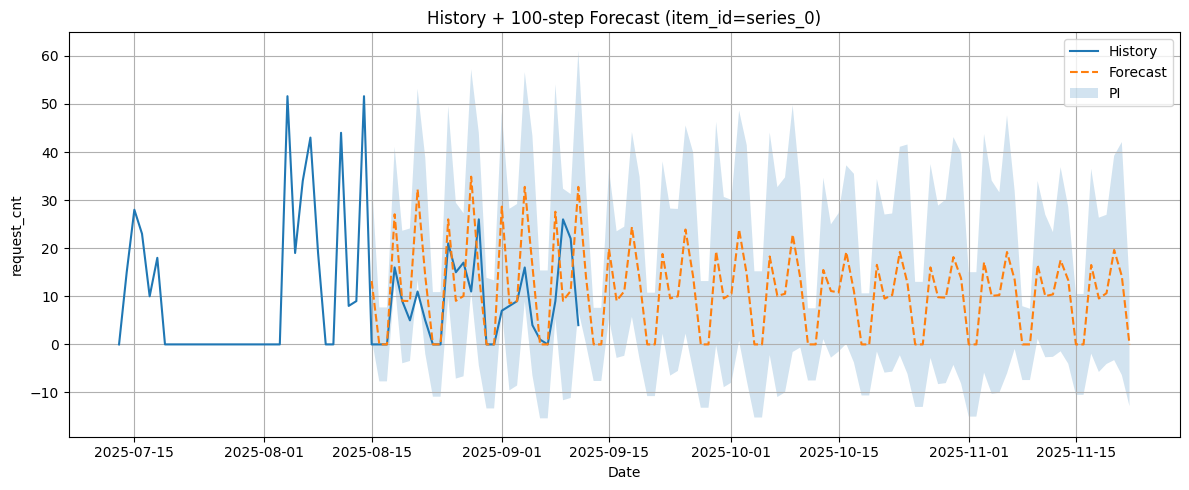

In [32]:
# ============================================
# 7.5) Plot: history + prediction horizon
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Helper: pick one series to plot (if you have multiple) ----
def pick_item_id(ts_df: pd.DataFrame) -> str:
    # ts_df is a TimeSeriesDataFrame or pandas DataFrame with columns ['item_id','timestamp','target',...]
    counts = (
        ts_df.reset_index()[["item_id", "timestamp"]]
        if {"item_id", "timestamp"}.issubset(ts_df.index.names or [])
        else ts_df[["item_id", "timestamp"]]
    )
    # choose the longest-history series
    return counts.groupby("item_id")["timestamp"].count().sort_values(ascending=False).index[0]

# Normalize inputs
hist_df = train_data.reset_index()[["item_id", "timestamp", "target"]].copy()
if 'target' not in hist_df.columns:  # fallback if older AG renamed target
    # try to find the first non-index numeric column
    cands = [c for c in hist_df.columns if c not in ("item_id", "timestamp")]
    if cands:
        hist_df = hist_df.rename(columns={cands[0]: "target"})

# Include test/holdout history if available to extend the line until the split
if isinstance(test_data, pd.DataFrame) and not test_data.empty:
    test_hist = test_data.reset_index()[["item_id", "timestamp", "target"]].copy()
    hist_df = pd.concat([hist_df, test_hist], ignore_index=True).sort_values(["item_id", "timestamp"])

# Prepare forecast frame from Step 7 (`future_fc`)
fc = future_fc.reset_index().copy()
# Standardize forecast column as 'y_hat'
if "mean" in fc.columns:
    fc = fc.rename(columns={"mean": "y_hat"})
else:
    cands = [c for c in fc.columns if c not in ("item_id", "timestamp")]
    if cands:
        fc = fc.rename(columns={cands[0]: "y_hat"})

# Choose which series to plot
item_to_plot = pick_item_id(hist_df)
print("Plotting item_id:", item_to_plot)

hist_one = hist_df[hist_df["item_id"] == item_to_plot].copy()
fc_one   = fc[fc["item_id"] == item_to_plot].copy()

# How much history to show
HISTORY_WINDOW_DAYS = 60  # change as needed
if not hist_one.empty:
    last_ts = hist_one["timestamp"].max()
    cutoff  = last_ts - pd.Timedelta(days=HISTORY_WINDOW_DAYS)
    hist_one = hist_one[hist_one["timestamp"] >= cutoff]

plt.figure(figsize=(12, 5))

# Plot history
plt.plot(hist_one["timestamp"], hist_one["target"], label="History")

# Plot forecast mean
plt.plot(fc_one["timestamp"], fc_one["y_hat"], label="Forecast", linestyle="--")

# Optional: plot prediction intervals if the columns exist (p10/p90 or 0.1/0.9)
lower_cols = [c for c in ("p10", "0.1", "q10", "q0.1") if c in fc_one.columns]
upper_cols = [c for c in ("p90", "0.9", "q90", "q0.9") if c in fc_one.columns]
if lower_cols and upper_cols:
    lo = fc_one[lower_cols[0]]
    hi = fc_one[upper_cols[0]]
    plt.fill_between(fc_one["timestamp"], lo.values, hi.values, alpha=0.2, label="PI")

plt.title(f"History + {len(fc_one)}-step Forecast (item_id={item_to_plot})")
plt.xlabel("Date")
plt.ylabel(TARGET_COL if 'TARGET_COL' in globals() else "target")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# =========================================
# 8) Export forecasts to CSV (+quantiles)
# =========================================
save_cols = ["item_id", "timestamp"]
# include mean if present; otherwise take the first numeric forecast col
if "mean" in future_fc.columns:
    save_cols.append("mean")
else:
    cands = [c for c in future_fc.columns if c not in ("item_id", "timestamp")]
    if cands:
        save_cols.append(cands[0])

# Optionally add quantiles if they exist
for q_col in ["p10", "p50", "p90", "0.1", "0.5", "0.9"]:
    if q_col in future_fc.columns and q_col not in save_cols:
        save_cols.append(q_col)

out_path = "forecast_next_{}_days.csv".format(FORECAST_DAYS)
future_fc.reset_index()[save_cols].to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: forecast_next_100_days.csv


In [34]:
# ===================================
# 9) Save & reload the best predictor
# ===================================
save_dir = "autogluon_timeseries_predictor"
predictor.save()
print("Predictor saved at:", predictor.path)
# To reload later (new session / production job):
from autogluon.timeseries import TimeSeriesPredictor as TSPredictor
predictor_reloaded = TSPredictor.load(predictor.path)

# Sanity-check: produce the same next-block forecast
pred_reloaded = predictor_reloaded.predict(train_data)
display(pred_reloaded.head())

Loading predictor from path /Users/katarov/PycharmProjects/flex-ml-python/AutogluonModels/ag-20250916_095753
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Predictor saved at: /Users/katarov/PycharmProjects/flex-ml-python/AutogluonModels/ag-20250916_095753


mean        0.1        0.5        0.9
item_id  timestamp                                             
series_0 2025-08-15  13.176471   1.253062  13.176471  34.629291
         2025-08-16   0.000000  -7.688115   0.000000   7.688115
         2025-08-17   0.000000  -7.688115   0.000000   7.688115
         2025-08-18  27.058824  13.017767  27.058824  41.099880
         2025-08-19   9.058824  -3.923409   9.058824  23.629291